## Gaussian Process Regression wit GPy

In [391]:
import pandas as pd

### 1. Read the data

In [392]:
all_positions = pd.read_csv('../interpolated-data/positions_xyz_2024-02-27_11h29m.csv', delimiter=',')
all_positions

,x,y,z
0,7.140000,3.070000,15.00000
1,10.140000,3.070000,15.00000
2,10.140000,3.070000,15.00000
3,10.140000,3.070000,15.00000
4,10.138330,3.169981,15.09998
...,...,...,...
500,5.179743,0.799010,12.72901
501,5.256516,0.734943,12.66494
502,5.335387,0.673466,12.60347
503,5.416258,0.614656,12.54466


In [393]:
all_red_ball_positions = pd.read_csv('../interpolated-data/red_ball_coordinates_128px_2024-02-27_11h29m.csv', delimiter=',')

all_red_ball_positions

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,0.0,42.0,87.0,39.0,34.853473,82.531266,44.0,83.0,89.0,83.0,28.886553,118.791444,69.0,122.0
1,0.5,42.5,87.0,40.0,34.853473,82.531266,45.0,84.0,89.0,84.0,28.886553,118.791444,68.5,120.5
2,0.5,43.5,87.0,41.0,34.853473,82.531266,45.0,85.0,89.0,85.0,28.886553,118.791444,68.5,120.5
3,1.0,45.0,87.5,42.0,34.853473,82.531266,45.0,86.0,89.0,86.0,28.886553,118.791444,68.5,120.5
4,1.0,45.5,88.0,43.0,34.853473,82.531266,45.0,86.0,90.0,87.0,28.886553,118.791444,68.5,120.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,68.0,10.0,55.0,26.0,64.000000,59.000000,111.0,59.0,59.5,69.0,54.500000,105.000000,68.0,118.5
497,67.0,9.0,55.0,26.0,63.000000,58.000000,110.0,58.0,59.5,69.0,54.000000,103.000000,68.0,118.5
498,66.0,8.0,55.0,26.0,62.000000,57.000000,109.0,57.0,59.5,69.0,53.000000,102.500000,68.0,118.5
499,65.0,5.0,55.0,26.0,61.000000,55.000000,107.5,55.0,59.5,69.0,52.000000,101.000000,68.0,118.5


In [394]:
all_positions = all_positions.iloc[4:]
all_positions.reset_index(drop=True, inplace=True)
all_red_ball_positions.shape,  all_positions.shape

((501, 14), (501, 3))

In [395]:
# Assuming all_red_ball_positions and all_positions are your DataFrames
combined_data = pd.concat([all_red_ball_positions, all_positions], axis=1)

# Remove all rows with 6 or more missing values not with thresh
combined_data = combined_data.dropna(thresh=combined_data.shape[1]-7)
combined_data

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,x,y,z
0,0.0,42.0,87.0,39.0,34.853473,82.531266,44.0,83.0,89.0,83.0,28.886553,118.791444,69.0,122.0,10.138330,3.169981,15.09998
1,0.5,42.5,87.0,40.0,34.853473,82.531266,45.0,84.0,89.0,84.0,28.886553,118.791444,68.5,120.5,10.133340,3.269852,15.19985
2,0.5,43.5,87.0,41.0,34.853473,82.531266,45.0,85.0,89.0,85.0,28.886553,118.791444,68.5,120.5,10.125010,3.369500,15.29950
3,1.0,45.0,87.5,42.0,34.853473,82.531266,45.0,86.0,89.0,86.0,28.886553,118.791444,68.5,120.5,10.113370,3.468816,15.39882
4,1.0,45.5,88.0,43.0,34.853473,82.531266,45.0,86.0,90.0,87.0,28.886553,118.791444,68.5,120.5,10.098430,3.567688,15.49769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,68.0,10.0,55.0,26.0,64.000000,59.000000,111.0,59.0,59.5,69.0,54.500000,105.000000,68.0,118.5,5.179743,0.799010,12.72901
497,67.0,9.0,55.0,26.0,63.000000,58.000000,110.0,58.0,59.5,69.0,54.000000,103.000000,68.0,118.5,5.256516,0.734943,12.66494
498,66.0,8.0,55.0,26.0,62.000000,57.000000,109.0,57.0,59.5,69.0,53.000000,102.500000,68.0,118.5,5.335387,0.673466,12.60347
499,65.0,5.0,55.0,26.0,61.000000,55.000000,107.5,55.0,59.5,69.0,52.000000,101.000000,68.0,118.5,5.416258,0.614656,12.54466


In [396]:
all_red_ball_positions = combined_data.iloc[:, :14]
all_positions = combined_data.iloc[:, 14:]
all_red_ball_positions.shape, all_positions.shape

((501, 14), (501, 3))

### 2. Handle Missing Values

In [397]:
from sklearn.impute import SimpleImputer, KNNImputer

imputer_mean = SimpleImputer(strategy='mean')
imputer_knn = KNNImputer(n_neighbors=2)
X_all = imputer_knn.fit_transform(all_red_ball_positions)
y_all = imputer_knn.fit_transform(all_positions)
X_all.shape, y_all.shape

((501, 14), (501, 3))

### 3. Prepare the Data

In [398]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)


In [399]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 14), (101, 14), (400, 3), (101, 3))

In [400]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled_train = scaler_x.fit_transform(X_train)
y_scaled_train = y_train

### 4. Train the Model

In [401]:
from GPy.kern import RBF
from GPy.models import GPRegression

#### 4.1 Train GP Regression Model with GPy for each output separately
For normal regression tasks

In [402]:
y_train_x = y_scaled_train[:, 0:1]
y_train_y = y_scaled_train[:, 1:2]
y_train_z = y_scaled_train[:, 2:3]

##### 4.1.1 Train GP Regression Model for X

In [403]:
kernel_x = RBF(input_dim=14)
model_x = GPRegression(X_scaled_train, y_train_x, kernel=kernel_x)
model_x.optimize(messages=True)

In [404]:
kernel_y = RBF(input_dim=14)
model_y = GPRegression(X_scaled_train, y_train_y, kernel=kernel_y)
model_y.optimize(messages=True)

In [405]:
kernel_z = RBF(input_dim=14)
model_z = GPRegression(X_scaled_train, y_train_z, kernel=kernel_z)
model_z.optimize(messages=True)

### 5. Make Predictions

In [406]:
X_scaled_test = scaler_x.transform(X_test)

#### 5.1 Predict with GP Regression Model

In [407]:
y_pred_reg_x, y_var_reg_x = model_x.predict(X_scaled_test)
y_pred_reg_y, y_var_reg_y = model_y.predict(X_scaled_test)
y_pred_reg_z, y_var_reg_z = model_z.predict(X_scaled_test)

### 6. Evaluate the Model

#### 6.1 Evaluate GP Regression Model

In [408]:
from utils.evaluate import evaluate_model

evaluate_model(y_test[:, 0], y_pred_reg_x, 'X Gaussian Process')

Mean Squared Error on X Gaussian Process Set: 0.0007416147410431637
Mean Absolute Error on X Gaussian Process Set: 0.02097199620731651
R2 Score on X Gaussian Process set: 0.9998456597284198


(0.0007416147410431637, 0.02097199620731651, 0.9998456597284198)

In [409]:
evaluate_model(y_test[:, 1], y_pred_reg_y, 'Y Gaussian Process')

Mean Squared Error on Y Gaussian Process Set: 0.0004043363326080792
Mean Absolute Error on Y Gaussian Process Set: 0.016009426303212684
R2 Score on Y Gaussian Process set: 0.9998990447542287


(0.0004043363326080792, 0.016009426303212684, 0.9998990447542287)

In [410]:
evaluate_model(y_test[:, 2], y_pred_reg_z, 'Z Gaussian Process')

Mean Squared Error on Z Gaussian Process Set: 0.0005648902570051162
Mean Absolute Error on Z Gaussian Process Set: 0.018147300006254287
R2 Score on Z Gaussian Process set: 0.9998589573973031


(0.0005648902570051162, 0.018147300006254287, 0.9998589573973031)

#### 6.2 Evaluate Sparse GP Regression Model

### 7. Visualize results

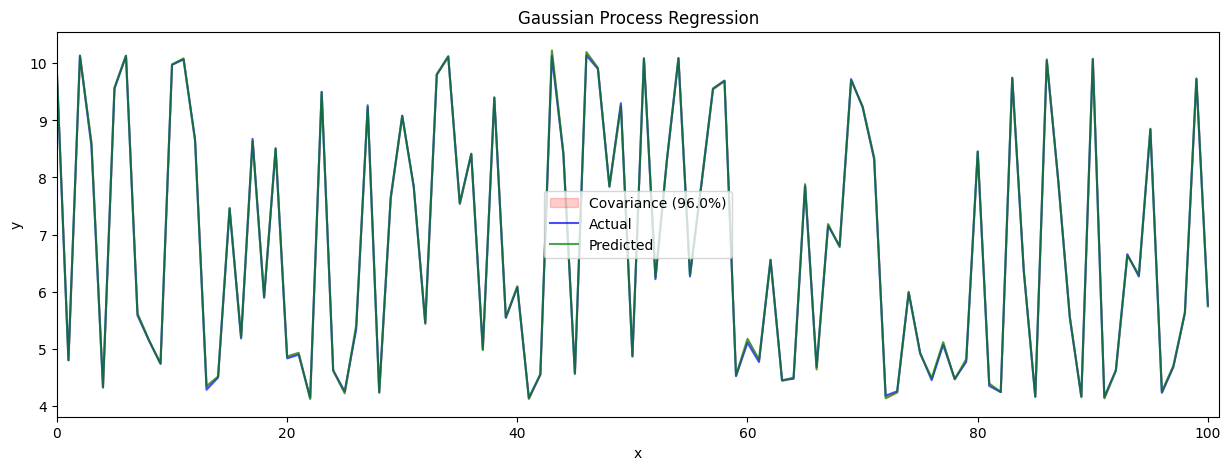

In [411]:
from utils.plot_maker_gaussian_process import gaussian_process_plot

gaussian_process_plot(y_test[:, 0], y_pred_reg_x[:, 0], y_var_reg_x[:, 0])


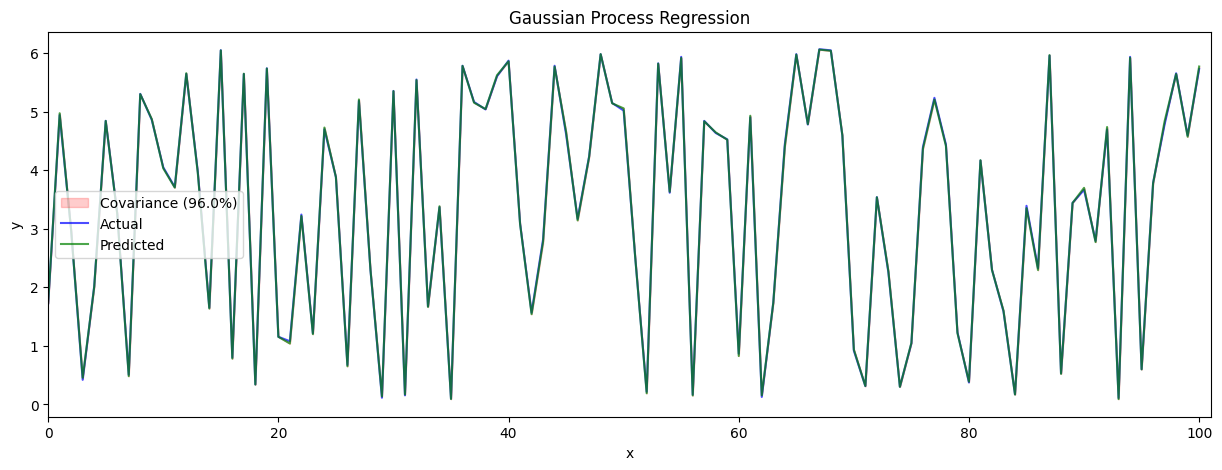

In [412]:
gaussian_process_plot(y_test[:, 1], y_pred_reg_y[:, 0], y_var_reg_y[:, 0])

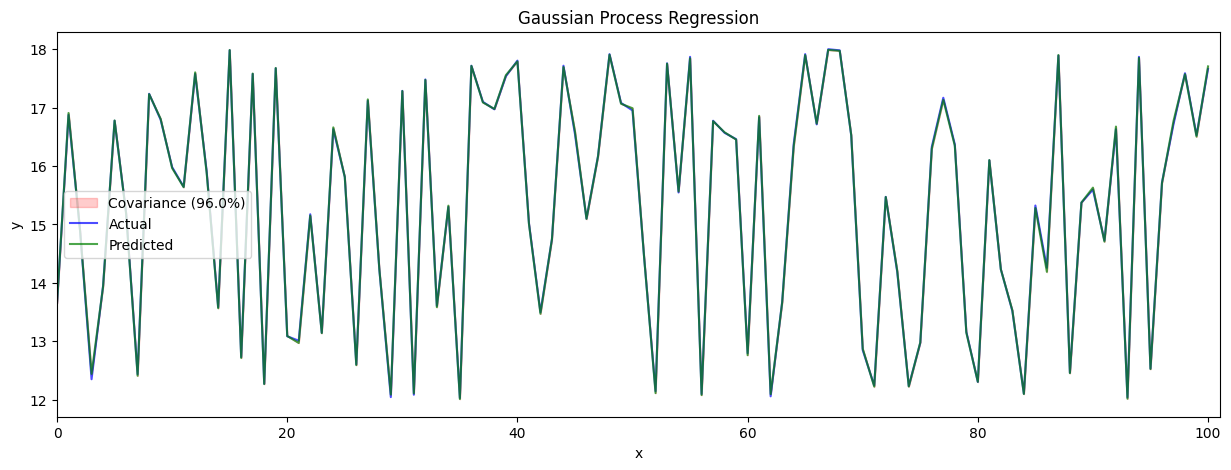

In [413]:
gaussian_process_plot(y_test[:, 2], y_pred_reg_z[:, 0], y_var_reg_z[:, 0])  

In [414]:
import numpy as np

# combine the results
y_pred_reg = np.concatenate((y_pred_reg_x, y_pred_reg_y, y_pred_reg_z), axis=1)
y_var_reg = np.concatenate((y_var_reg_x, y_var_reg_y, y_var_reg_z), axis=1)

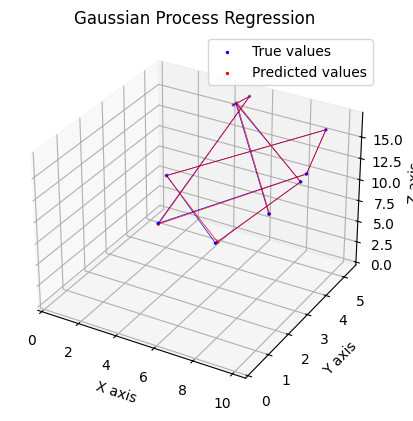

In [415]:
from utils.plot_maker_gaussian_process import plot_maker_3d

plot_maker_3d(y_test[:10], y_pred_reg[:10], 'Gaussian Process Regression')

#### 8. Make prediction on new data

In [416]:
X = pd.read_csv('../interpolated-data/red_ball_coordinates_128px_2024-02-27_13h38m.csv', delimiter=',')
X = imputer_knn.fit_transform(X)

In [417]:
y = pd.read_csv('../interpolated-data/positions_xyz_2024-02-27_13h38m.csv', delimiter=',')
y = y.iloc[4:]
y

,x,y,z
4,7.156666,3.169981,15
5,7.173333,3.269852,15
6,7.189999,3.369500,15
7,7.206665,3.468816,15
8,7.223330,3.567688,15
...,...,...,...
1473,2.227737,0.208745,15
1474,2.230873,0.240388,15
1475,2.234063,0.275175,15
1476,2.237308,0.313067,15


In [418]:
y_new_pred_x, y_new_var_x = model_x.predict(scaler_x.transform(X))
y_new_pred_y, y_new_var_y = model_y.predict(scaler_x.transform(X))
y_new_pred_z, y_new_var_z = model_z.predict(scaler_x.transform(X))

In [419]:
evaluate_model(y.x, y_new_pred_x, 'X Gaussian Process')
evaluate_model(y.y, y_new_pred_y, 'Y Gaussian Process')
evaluate_model(y.z, y_new_pred_z, 'Z Gaussian Process')

Mean Squared Error on X Gaussian Process Set: 7.590845530331292
Mean Absolute Error on X Gaussian Process Set: 1.9665868732744793
R2 Score on X Gaussian Process set: 0.38510235416975636
Mean Squared Error on Y Gaussian Process Set: 2.320587980578996
Mean Absolute Error on Y Gaussian Process Set: 1.0480869248804794
R2 Score on Y Gaussian Process set: 0.4884103238546199
Mean Squared Error on Z Gaussian Process Set: 7.874930102074208
Mean Absolute Error on Z Gaussian Process Set: 2.4889904817265336
R2 Score on Z Gaussian Process set: 0.0


(7.874930102074208, 2.4889904817265336, 0.0)

In [420]:
y_new_pred = np.concatenate((y_new_pred_x, y_new_pred_y, y_new_pred_z), axis=1)
y_new_var = np.concatenate((y_new_var_x, y_new_var_y, y_new_var_z), axis=1)

In [421]:
y.shape, y_new_pred.shape, y_new_var.shape

((1474, 3), (1474, 3), (1474, 3))

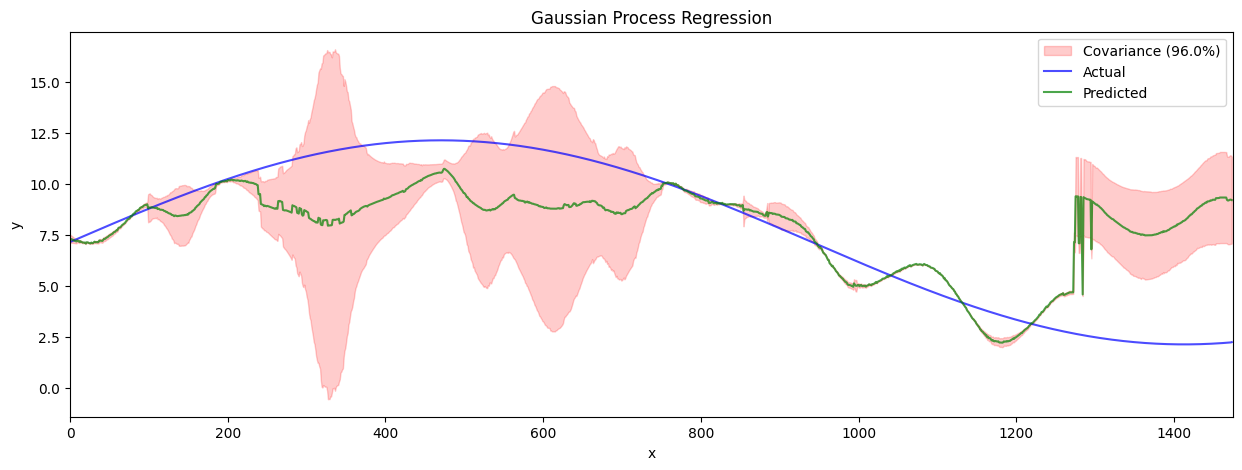

In [422]:
gaussian_process_plot(y.x, y_new_pred_x[:, 0], y_new_var_x[:, 0])

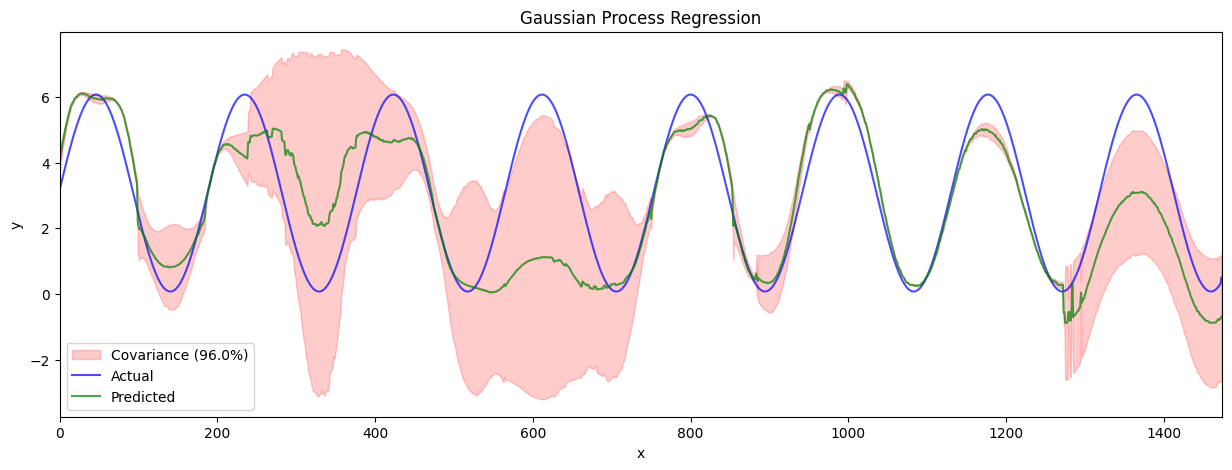

In [423]:
gaussian_process_plot(y.y, y_new_pred_y[:, 0], y_new_var_y[:, 0])

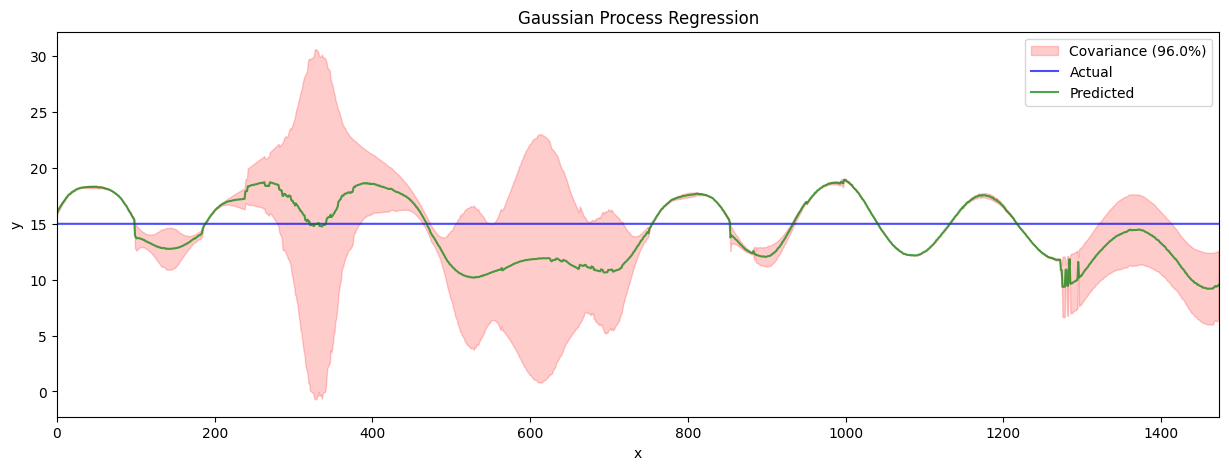

In [424]:
gaussian_process_plot(y.z, y_new_pred_z[:, 0], y_new_var_z[:, 0])

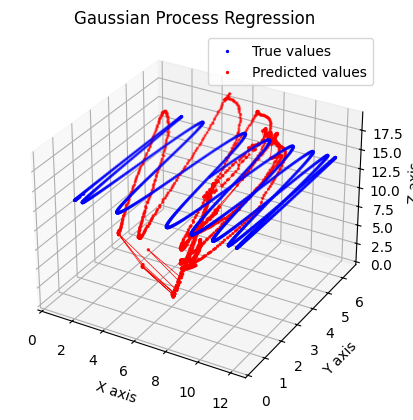

In [427]:
plot_maker_3d(y.to_numpy(), y_new_pred, 'Gaussian Process Regression')